In [2]:
%load_ext autoreload
%autoreload 2

In [40]:
from net import NeuralNet
from utils import *
import mnist_loader
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from scipy.stats import bernoulli

## Data Loading
- In this project, I use the popular dataset MNIST (hand-written digits) to test the performance of my implememtation for neural network.
- The dataset including:
    1. 50000 train data
    2. 10000 validation data
    3. 10000 test data

In [4]:
# Load train, valid, and test dataset:
training_data, validation_data, test_data = mnist_loader.load_data()

In [5]:
# Split the features and target data:
X_train, y_train = training_data[0].T, training_data[1].T
X_valid, y_valid = validation_data[0].T, validation_data[1].T
X_test, y_test = test_data[0].T, test_data[1].T
# One-hot encode the label for each target digit:
y_train_1hot = one_hot(y_train, 10)
y_valid_1hot = one_hot(y_valid, 10)
y_test_1hot = one_hot(y_test, 10)

## Parameter Selection
- Tuning parameters for neural network can be a daunting job. In this setting, I decide to use a network with 3 layers to avoid **exloding gradient** (in the future I will try to study and implement **Residual Net** for this issue). Then I proceed to find some good value for **learning rate** and **hidden layer's size**. 
- From my experience, I would let the batch size to be small, so that the network would update parameters more frequently and converge faster without many epochs. Here I set the epoch to be 5, but 3 is already good.

In [ ]:
# Perform grid search to find the best configuration for learning rate hidden layer size:
etas = np.linspace(10**-2, 10**-5, 50)
hids = np.array([2**i for i in range(5, 10)])
accu = np.zeros((len(etas), len(hids)))
for i in range(len(etas)):
    for j in range(len(hids)):
        eta = etas[i]
        hid = hids[j]
        net_valid = NeuralNet(sizes=[784, hid, 10], dropout=(0.9, 0.5), eta=eta, epochs=5, batch_size=128)
        net_valid.fit(X_valid, y_valid_1hot)
        accuracy = net_valid.accuracy(X_valid, y_valid)
        accu[i, j] = accuracy
        #print('Model: eta = %f | Hidden Size = %d | Achieved Accuracy: %f' % (eta, hid, accuracy))

- With this heatmap of the all models' accuracy, we can see that more complicated networks (large hidden layer size) usually make better prediction. 
- Good learning rates are roughly around 0.003 to 0.0006
- Upon this result, I just find the configuration with the highest accuracy and continue to traning phase.

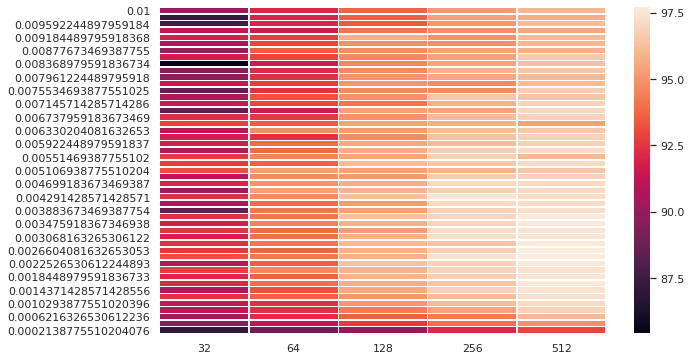

In [41]:
# Choose the best value for parameters:
indices = np.unravel_index(np.argmax(accu, axis=None), accu.shape)
eta = etas[indices[0]]
hidden_size = hids[indices[1]]
import seaborn as sns
accu_df = pd.DataFrame(accu[:-1, :], columns=hids, index=etas[:-1])
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(accu_df, linewidths=.5, ax=ax)

## Model Training
- With the parameter configuration obtained from the validation step, I proceed to train the model with the train dataset. Here I plot the costs of the model vs. training step. Observe that the model converges quite fast after around 100 iterations. 
- With **dropout**, the model does not overfit to the data, as the accuracy for train and test set are almost the same at 97%

In [20]:
# Train model on train dataset:
net = NeuralNet(sizes=[784, hidden_size, 10], dropout=(0.9, 0.5), eta=eta, epochs=5, batch_size=128)
net.fit(X_train, y_train_1hot)

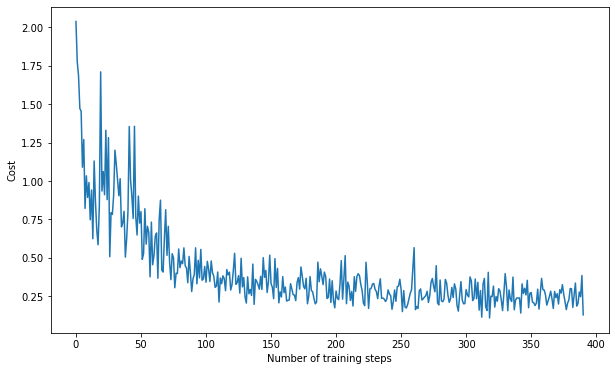

Train accuracy: 97.900000 ---- Test accuracy: 97.090000


In [21]:
# Plot the costs:
plt.figure(figsize=(10,6))
plt.plot(net.costs)
plt.xlabel('Number of training steps')
plt.ylabel('Cost')
plt.show()
# Accuracy of train and test set:
train_accuracy = net.accuracy(X_train, y_train)
test_accuracy = net.accuracy(X_test, y_test)
print('Train accuracy: %f ---- Test accuracy: %f' % (train_accuracy, test_accuracy))